In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 2-halo effects

In [2]:
# load a test halo catalog

from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolshoi', halo_finder='rockstar', redshift=0.0, dz_tol=0.001, version_name='halotools_v0p4')

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Calulate Orientation Correlation Functions

In [3]:
from halotools.mock_observables.alignments import ed_3d, ee_3d, ee_3d_one_two_halo_decomp, ed_3d_one_two_halo_decomp

rbins = np.logspace(-1,1.4,20)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

In [4]:
# empirical halo and sub-halo correlations

halo_coords = np.vstack((halocat.halo_table['halo_x'],
                         halocat.halo_table['halo_y'],
                         halocat.halo_table['halo_z'])).T

halo_orientations = np.vstack((halocat.halo_table['halo_axisA_x'],
                               halocat.halo_table['halo_axisA_y'],
                               halocat.halo_table['halo_axisA_z'])).T

# define host and sub-halo samples
hosts = halocat.halo_table['halo_upid']==-1
subs = halocat.halo_table['halo_upid']!=-1

# define host halo IDs
host_ids = halocat.halo_table['halo_hostid']

# define halo sub-samples
halo_sample_mask = (halocat.halo_table['halo_mpeak']>10**12.0)

In [5]:
from halotools.mock_observables.alignments import ed_3d, ee_3d

rbins = np.logspace(-1,1.4,20)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

In [6]:
# calculate ED correaltion functions
halo_omega = ed_3d(halo_coords[halo_sample_mask], halo_orientations[halo_sample_mask],
                                     halo_coords[halo_sample_mask],
                                     rbins, period=halocat.Lbox, num_threads=4)

In [7]:
# calculate EE correaltion functions
halo_eta = ee_3d(halo_coords[halo_sample_mask], halo_orientations[halo_sample_mask],
                             halo_coords[halo_sample_mask], halo_orientations[halo_sample_mask],
                             rbins, period=halocat.Lbox, num_threads=4)

## vary central alignment strength

In [8]:
from intrinsic_alignments.ia_models.utils import halocat_to_galaxy_table
from intrinsic_alignments.ia_models.ia_model_components import CentralAlignment
from intrinsic_alignments.ia_models.ia_model_components import RadialSatelliteAlignment

def calculate_ed(central_alignment_strength, num_realizations=10):
    
    rbins = np.logspace(-1,1.4,20)
    
    gal_omega = np.zeros((num_realizations, len(rbins)-1))
    gal_eta = np.zeros((num_realizations, len(rbins)-1))
    
    for i in range(0, num_realizations):
        print(i)
        
        table = halocat_to_galaxy_table(halocat)
        
        #central alignments
        cen_alignment_model = CentralAlignment(central_alignment_strength=central_alignment_strength)
        table = np.copy(cen_alignment_model.assign_central_orientation(table=table))
        
        #satellite alignments
        sats = (table['gal_type']=='satellites')
        table['galaxy_axisA_x'][sats] = halocat.halo_table['halo_axisA_x'][sats]
        table['galaxy_axisA_y'][sats] = halocat.halo_table['halo_axisA_y'][sats]
        table['galaxy_axisA_z'][sats] = halocat.halo_table['halo_axisA_z'][sats]
        
        galaxy_coords = np.vstack((table['x'],
                                   table['y'],
                                   table['z'])).T

        galaxy_orientations = np.vstack((table['galaxy_axisA_x'],
                                         table['galaxy_axisA_y'],
                                         table['galaxy_axisA_z'])).T

        gal_sample_mask = table['halo_mpeak']>10**12.0
        
        gal_omega[i,:] = ed_3d(galaxy_coords[gal_sample_mask], galaxy_orientations[gal_sample_mask],
                               galaxy_coords[gal_sample_mask],
                               rbins, period=halocat.Lbox, num_threads=4)
        
        gal_eta[i,:] = ee_3d(galaxy_coords[gal_sample_mask], galaxy_orientations[gal_sample_mask],
                             galaxy_coords[gal_sample_mask], galaxy_orientations[gal_sample_mask],
                             rbins, period=halocat.Lbox, num_threads=4)

    return np.mean(gal_omega, axis=0), np.mean(gal_eta, axis=0)

In [9]:
gal_omega_1, gal_eta_1 = calculate_ed(0.99, num_realizations=2)

0


/Users/duncan/Projects/intrinsic_alignments/ia_models/ia_model_components.py:111: UserWarning: `central_alignment_strength` not detected in the table, using value in self.param_dict.
  warn(msg)


1


In [10]:
gal_omega_2, gal_eta_2 = calculate_ed(0.9, num_realizations=2)

0
1


In [11]:
gal_omega_3, gal_eta_3 = calculate_ed(0.8, num_realizations=2)

0
1


In [12]:
gal_omega_4, gal_eta_4 = calculate_ed(0.7, num_realizations=2)
gal_omega_5, gal_eta_5 = calculate_ed(0.6, num_realizations=2)
gal_omega_6, gal_eta_6 = calculate_ed(0.5, num_realizations=2)

0
1
0
1
0
1


In [13]:
gal_omega_9, gal_eta_9 = calculate_ed(-0.99, num_realizations=2)

0
1


TypeError: show() got an unexpected keyword argument 'dpi'

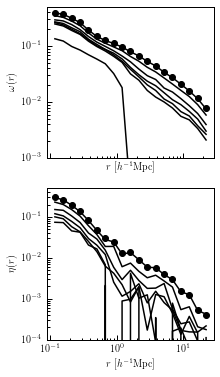

In [14]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(3.3,6.6))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)

ax = ax1
l1, = ax.plot(rbin_centers, halo_omega, 'o', color='black')
l2, = ax.plot(rbin_centers, gal_omega_1, '-', color='black')
l2, = ax.plot(rbin_centers, gal_omega_2, '-', color='black')
l2, = ax.plot(rbin_centers, gal_omega_3, '-', color='black')
l2, = ax.plot(rbin_centers, gal_omega_4, '-', color='black')
l2, = ax.plot(rbin_centers, gal_omega_5, '-', color='black')
l2, = ax.plot(rbin_centers, gal_omega_6, '-', color='black')
l2, = ax.plot(rbin_centers, gal_omega_9, '-', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$')
ax.set_ylabel(r'$\omega(r)$')
ax.set_ylim([0.001,0.5])

ax = ax2
l1, = ax.plot(rbin_centers, halo_eta, 'o', color='black')
l1, = ax.plot(rbin_centers, gal_eta_1, '-', color='black')
l1, = ax.plot(rbin_centers, gal_eta_2, '-', color='black')
l1, = ax.plot(rbin_centers, gal_eta_3, '-', color='black')
l1, = ax.plot(rbin_centers, gal_eta_4, '-', color='black')
l1, = ax.plot(rbin_centers, gal_eta_5, '-', color='black')
l1, = ax.plot(rbin_centers, gal_eta_6, '-', color='black')
l1, = ax.plot(rbin_centers, gal_eta_9, '-', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$')
ax.set_ylabel(r'$\eta(r)$')
ax.set_ylim([0.0001,0.5])


plt.show('/Users/duncan/Desktop/varying_central_alignment.pdf', =300)

fig.savefig()

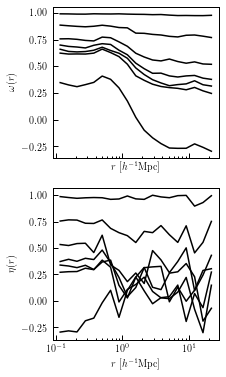

In [57]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(3.3,6.6))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)

ax = ax1
l2, = ax.plot(rbin_centers, gal_omega_1/halo_omega, '-', color='black')
l2, = ax.plot(rbin_centers, gal_omega_2/halo_omega, '-', color='black')
l2, = ax.plot(rbin_centers, gal_omega_3/halo_omega, '-', color='black')
l2, = ax.plot(rbin_centers, gal_omega_4/halo_omega, '-', color='black')
l2, = ax.plot(rbin_centers, gal_omega_5/halo_omega, '-', color='black')
l2, = ax.plot(rbin_centers, gal_omega_6/halo_omega, '-', color='black')
l2, = ax.plot(rbin_centers, gal_omega_9/halo_omega, '-', color='black')
ax.set_xscale('log')
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$')
ax.set_ylabel(r'$\omega(r)$')
#ax.set_ylim([0,1.1])

ax = ax2
l1, = ax.plot(rbin_centers, gal_eta_1/halo_eta, '-', color='black')
l1, = ax.plot(rbin_centers, gal_eta_2/halo_eta, '-', color='black')
l1, = ax.plot(rbin_centers, gal_eta_3/halo_eta, '-', color='black')
l1, = ax.plot(rbin_centers, gal_eta_4/halo_eta, '-', color='black')
l1, = ax.plot(rbin_centers, gal_eta_5/halo_eta, '-', color='black')
l1, = ax.plot(rbin_centers, gal_eta_6/halo_eta, '-', color='black')
l1, = ax.plot(rbin_centers, gal_eta_9/halo_eta, '-', color='black')
ax.set_xscale('log')
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$')
ax.set_ylabel(r'$\eta(r)$')
#ax.set_ylim([0,1.1])


plt.show()

plt.show('/Users/duncan/Desktop/varying_central_alignment_normalized.pdf', dpi=300)